## This piece of code is an example in excessive memory allocation :(

In [1]:
import warnings

warnings.simplefilter('ignore')

In [2]:
import bisect
import collections
import random

import numpy as np
import tables

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd

from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.svm import LinearSVC

from IPython.display import Image
import pydotplus as pydot

In [3]:
parents = [['AD0231-C', 'AD0232-C'], ['AD0254-C', 'AD0255-C'],
           ['AD0305-C', 'AD0306-C'], ['AD0347-C', 'AD0348-C']]

crosses_3L_h5 = '../raw/crosses-3L.h5'

In [4]:
def get_offspring_range(parents, all_parents, samples):
    my_index = samples.index(parents[1])
    start = my_index + 1
    parents_position = all_parents.index(parents)
    if  parents_position == len(all_parents) - 1:
        end = len(samples)
    else:
        end = samples.index(all_parents[parents_position + 1][0])
    return start, end

In [5]:
store_3L = tables.open_file(crosses_3L_h5, 'r')

In [6]:
samples = [x.decode('utf-8') for x in store_3L.get_node('/3L/samples').read()]

In [7]:
def compute_medelian_errors(parents, offspring):
    #autosome only
    mo_alleles = set(parents[0])
    fa_alleles = set(parents[1])
    if set([-1]) in [mo_alleles, fa_alleles]:
        return
    if len(mo_alleles) == 2 and len(fa_alleles) == 2:
        #Both HZ, this case it not trivial
        return
    cnt = cnt_mo = cnt_fa = total = 0
    for ofs in offspring:
        my_alleles = set(ofs)
        if set(ofs) == set([-1]):
            continue
        total += 1
        if len(my_alleles & mo_alleles) == 0:
            cnt += 1
            cnt_mo += 1
        if len(my_alleles & fa_alleles) == 0:
            cnt += 1
            cnt_fa += 1
        # Ofspring has more alleles (hz) than parents
        if len(my_alleles) > len(fa_alleles | mo_alleles):
            cnt += 1
    return total, cnt, cnt_mo, cnt_fa
#discuss probs of 01 01 01 01 01 if both parents hz

In [8]:
poses = store_3L.get_node('/3L/variants/POS').read()
num_alleles = store_3L.get_node('/3L/variants/num_alleles').read()
genotypes = store_3L.get_node('/3L/calldata/genotype').read() #

In [9]:
my_parents = parents[0]
ofs_mo = samples.index(my_parents[0])
ofs_fa = samples.index(my_parents[1])
ofs_start, ofs_end = get_offspring_range(my_parents, parents, samples)

i = 0
mendel_results = {}
has_errors = []
for pos, na, genotype in zip(poses, num_alleles, genotypes):
    i += 1
    if random.randint(0, 100) < 90:
        continue
    if na != 2:
        continue
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    errors = compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    if errors is None:
        continue
    if errors[1] > 0:
        has_errors.append(pos)
    mendel_results[pos] = i, errors

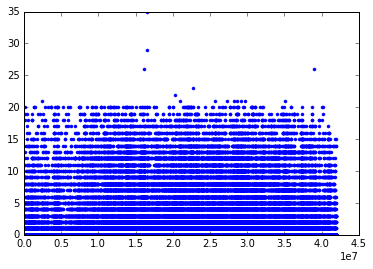

In [10]:
x, y = zip(*((pos, error[1][1]) for pos, error in mendel_results.items()))
plt.plot(x, y, '.')

In [11]:
window_size = 250000
max_pos = max(mendel_results.keys())
num_bins = max_pos // window_size + 1
wins = [[0, 0] for x in range(num_bins)]
for pos in mendel_results:
    wins[pos // window_size][0] += 1
for pos, err in mendel_results.items():
    if err[1][1] == 0:
        continue
    wins[pos // window_size][1] += 1
frac_errors = [errs / poses for poses, errs in wins]

0.13935670522732108

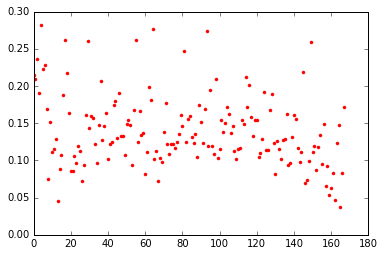

In [12]:
plt.plot(frac_errors, '.', c='r')
sum(frac_errors)/len(frac_errors)

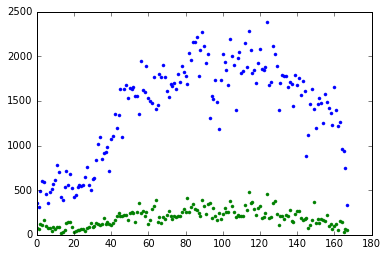

In [13]:
plt.plot([poses for poses in wins], '.')

In [14]:
#errors by annotation type

In [15]:
for entry in store_3L.get_node('/3L/variants'):
    print(entry)

/3L/variants/AC (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AF (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ALT (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ANN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Accessible (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/BaseCounts (EArray(2501730, 4), shuffle, zlib(1)) ''
/3L/variants/BaseQRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CHROM (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ClippingRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Coverage (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CoverageMQ0 (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DP (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DS (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Dels (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_LowQual (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_PASS (EAr

In [16]:
annotations = ['AC', 'AF', 'AN', 'Coverage', 'DP', 'HRun', 'HaplotypeScore', 'InbreedingCoeff',
              'MLEAC', 'MQ', 'MQ0', 'QD', 'QUAL', 'POS', 'FS']

In [17]:
def get_train(annotations, return_scaler=False, normalize=True, scale=True):
    train_X = []
    train_Y = []
    scaler = preprocessing.StandardScaler()
    #This is silly (memory-wise)
    annot_dict = {}
    for annotation in annotations:
        annot_dict[annotation] = store_3L.get_node('/3L/variants/%s' % annotation).read()

    for i, pos in enumerate(poses):
        try:
            if pos not in mendel_results:
                continue
        except IndexError:
            continue
        #if pos not in has_errors:
        #    # We throw away 90% of good positions
        #    if random.randint(0, 100) > 10:
        #        continue
        my_entry = []
        for annotation in annotations:
            my_entry.append(annot_dict[annotation][i])
        train_X.append(my_entry)
        train_Y.append(0 if pos in has_errors else 1)

    #train_pre = preprocessing.normalize(preprocessing.scale(train_X))
    if normalize:
        pre_pre = preprocessing.normalize(train_X)
    else:
        pre_pre = train_X
    if scale:
        train_pre = scaler.fit_transform(pre_pre)
    else:
        train_pre = pre_pre
    #train_pre = preprocessing.scale(train_X)
    train_pre = pd.DataFrame(train_pre, columns=annotations)
    train_pre['OK'] = pd.Series(train_Y, index=train_pre.index)
    if return_scaler:
        return train_pre, scaler
    else:
        return train_pre

In [18]:
train_raw = get_train(annotations, normalize=False, scale=False)

In [19]:
train_pre = get_train(annotations)

In [20]:
train_no_norm = get_train(annotations, normalize=False)

## Exploratory analysis

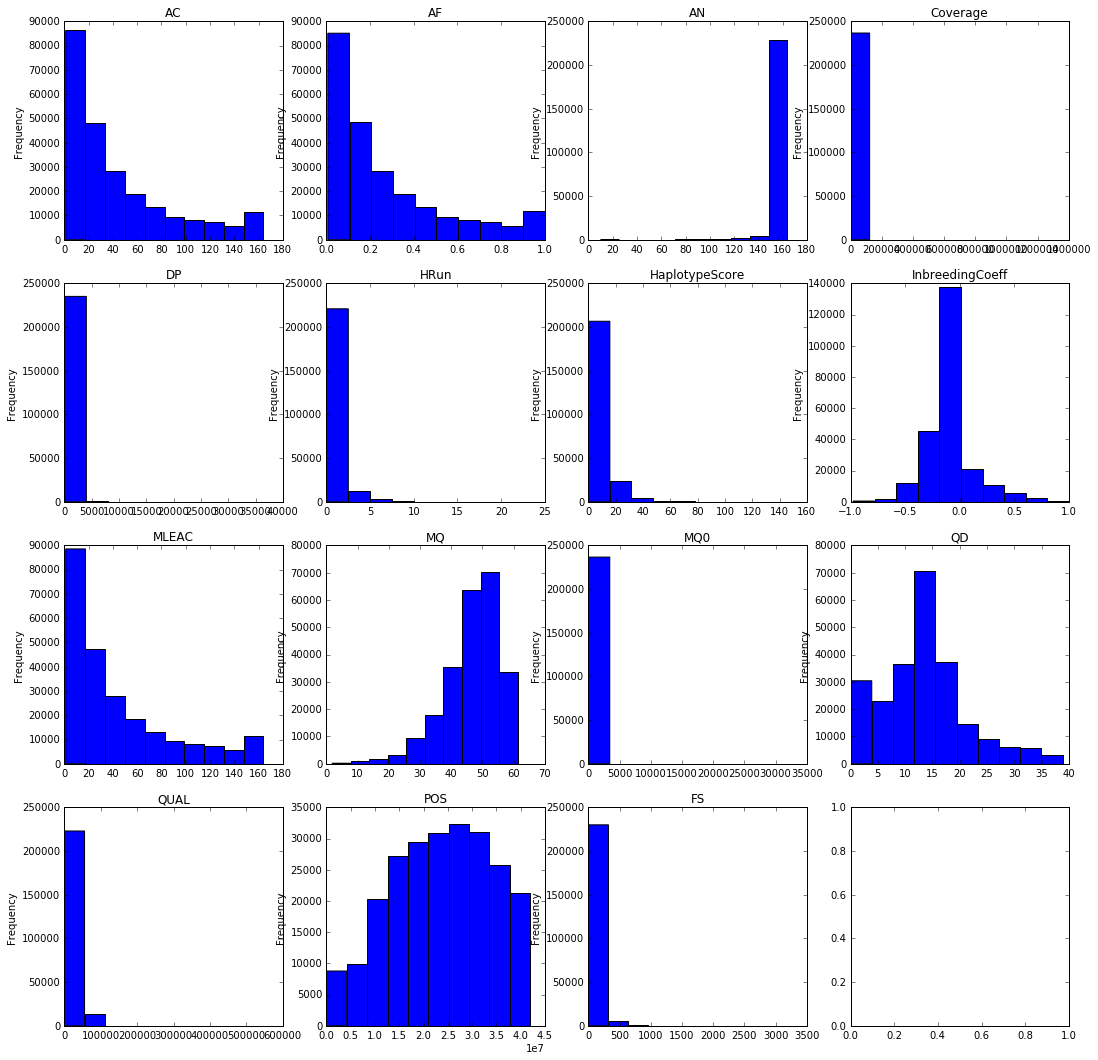

In [21]:
ncols = 4
fig, axs = plt.subplots(4, ncols, figsize=(18, 18), squeeze=False)
row = 0
col = 0
for annotation in annotations:
    train_raw[annotation].plot.hist(ax=axs[row, col])
    axs[row, col].set_title(annotation)
    col += 1
    if col == ncols:
        col = 0
        row += 1

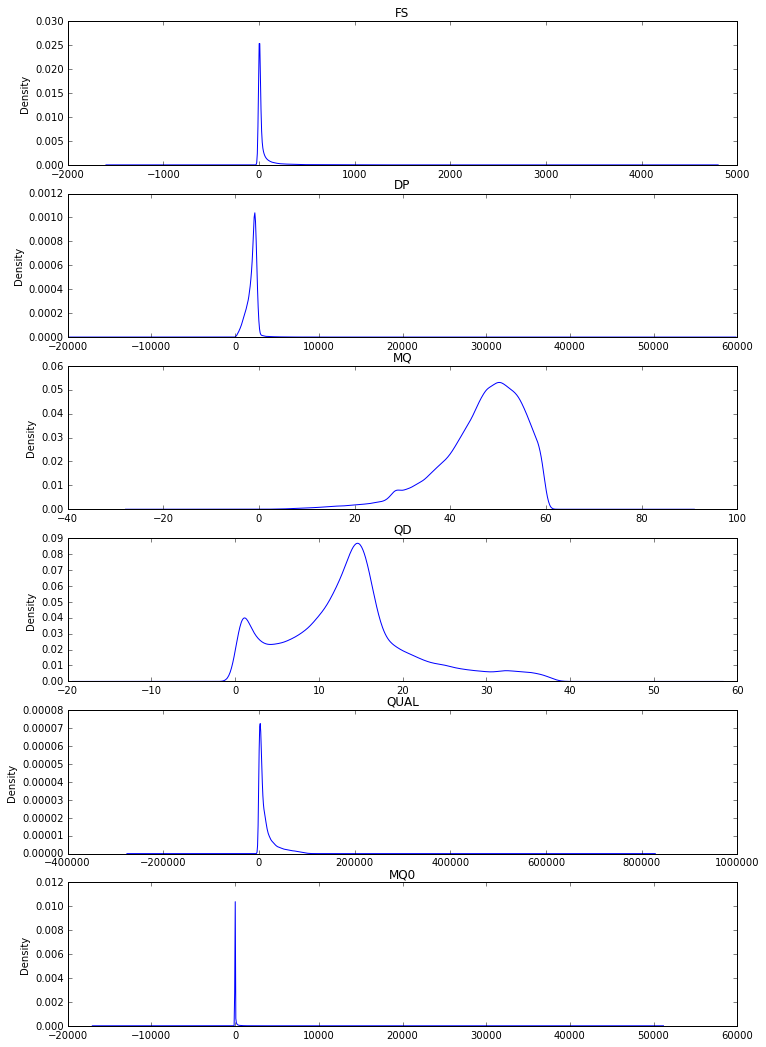

In [22]:
my_annotations = ['FS', 'DP', 'MQ', 'QD', 'QUAL', 'MQ0']
fig, axs = plt.subplots(len(my_annotations), figsize=(12, 18))
for i, annotation in enumerate(my_annotations):
    train_raw[annotation].plot.kde(ax=axs[i])
    axs[i].set_title(annotation)

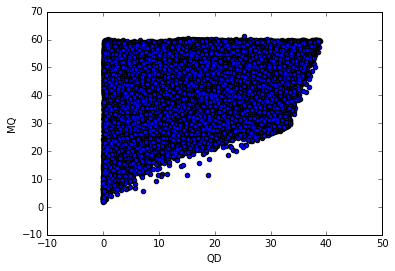

In [23]:
train_raw.plot.scatter(x='QD', y='MQ')

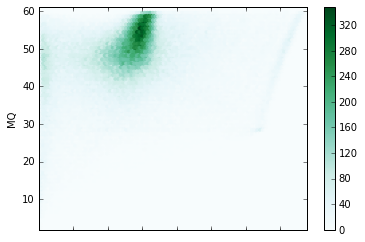

In [24]:
train_raw.plot.hexbin(x='QD', y='MQ')

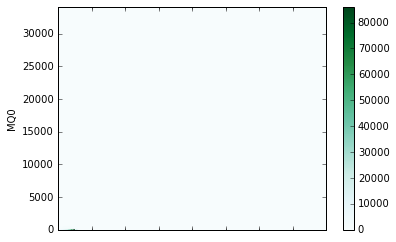

In [25]:
train_raw.plot.hexbin(x='DP', y='MQ0')

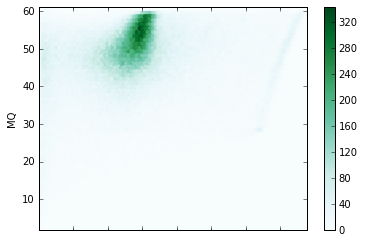

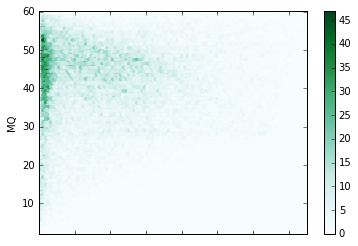

In [26]:
train_raw[train_raw['OK'] == 1].plot.hexbin(x='QD', y='MQ')
train_raw[train_raw['OK'] == 0].plot.hexbin(x='QD', y='MQ')

(0, 60)

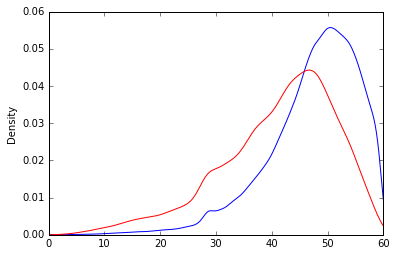

In [27]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['MQ'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['MQ'].plot.kde(ax=ax, c='r')
ax.set_xlim(0, 60)


(-100, 200)

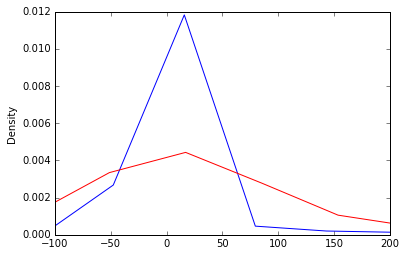

In [28]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['MQ0'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['MQ0'].plot.kde(ax=ax, c='r')
ax.set_xlim(-100, 200)

(0, 40)

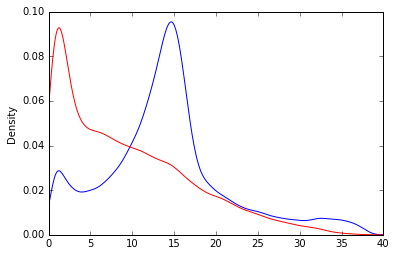

In [29]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['QD'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['QD'].plot.kde(ax=ax, c='r')
ax.set_xlim(0, 40)

(150, 175)

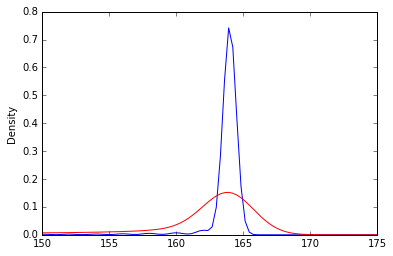

In [30]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['AN'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['AN'].plot.kde(ax=ax,c='r')
ax.set_xlim(150, 175)

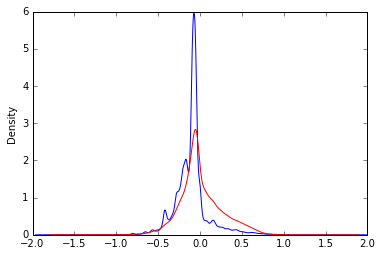

In [31]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['InbreedingCoeff'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['InbreedingCoeff'].plot.kde(ax=ax,c='r')
#ax.set_xlim(150, 175)

(0, 200)

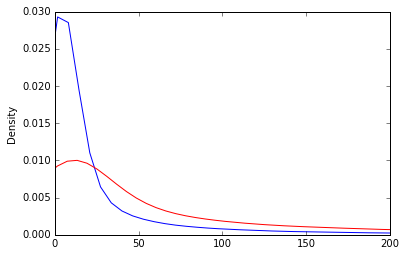

In [32]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['FS'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['FS'].plot.kde(ax=ax,c='r')
ax.set_xlim(0, 200)

(0, 5000)

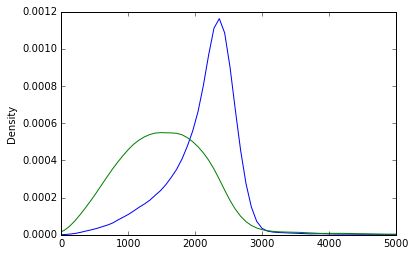

In [33]:
fig, ax = plt.subplots(1)
train_raw[train_raw['OK'] == 1]['DP'].plot.kde(ax=ax)
train_raw[train_raw['OK'] == 0]['DP'].plot.kde(ax=ax)
ax.set_xlim(0, 5000)

In [34]:
def filter_hard(snp, qd=5):
    if snp['DP'] < 1500 or snp['QD'] < qd or snp['MQ0'] < -50 or snp['MQ0'] > 100:
        return True
    return False

In [35]:
def quantify_filter(qd=5):
    snps_passed = 0
    snps_failed = 0
    good_snps_filtered = 0
    bad_snps_approved = 0
    for id_, snp in train_raw.iterrows():
        filtered_out = filter_hard(snp, qd)
        if filtered_out:
            snps_failed += 1
            if snp['OK'] == 1:
                good_snps_filtered += 1
        else:
            snps_passed += 1
            if snp['OK'] == 0:
                bad_snps_approved += 1
    return snps_passed, snps_failed, good_snps_filtered, bad_snps_approved, bad_snps_approved / snps_passed

print(quantify_filter())
print(quantify_filter(10))

(166730, 70207, 45850, 8248, 0.04946920170335273)
(143017, 93920, 66793, 5478, 0.03830313878769657)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb72d4ac710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb725dfb9b0>]], dtype=object)

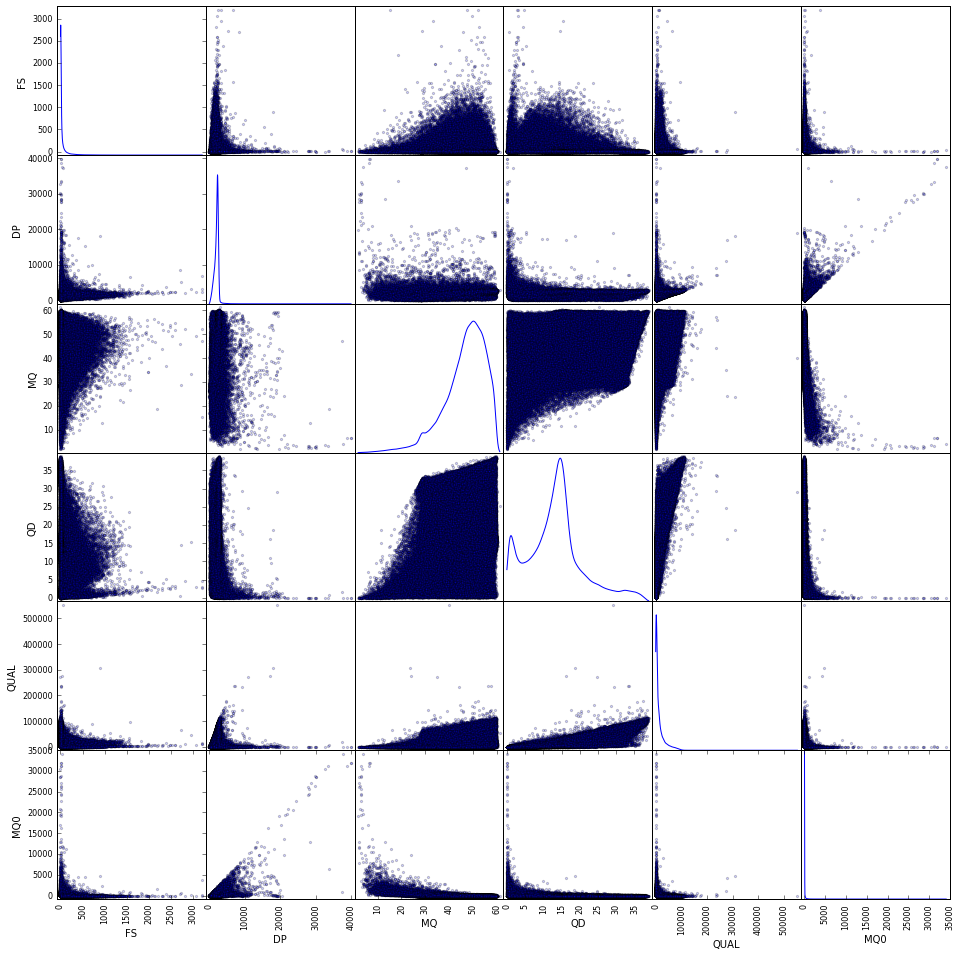

In [36]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(train_raw[my_annotations], alpha=0.2, figsize=(16, 16), diagonal='kde')


(0, 3000)

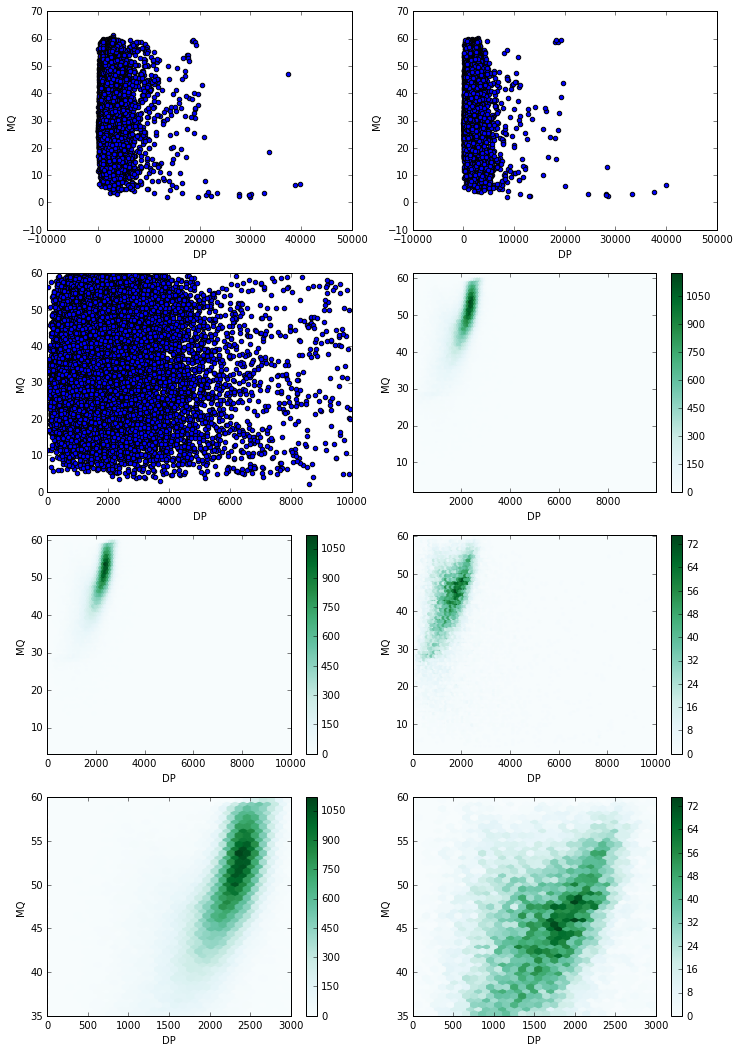

In [37]:
fix, axs = plt.subplots(4, 2, figsize=(12, 18), squeeze=False)

train_raw[train_raw['OK'] == 1].plot.scatter(x='DP', y='MQ', ax=axs[0, 0])
train_raw[train_raw['OK'] == 0].plot.scatter(x='DP', y='MQ', ax=axs[0, 1])


curb_dp = train_raw[train_raw['DP'] < 10000]

curb_dp.plot.scatter(x='DP', y='MQ', ax=axs[1, 0])
axs[1, 0].set_xlim(0, 10000)
axs[1, 0].set_ylim(0, 60)
curb_dp.plot.hexbin(x='DP', y='MQ', ax=axs[1, 1])

curb_dp[curb_dp['OK'] == 1].plot.hexbin(x='DP', y='MQ', ax=axs[2, 0])
axs[2, 0].set_xlim(0, 10000)
curb_dp[curb_dp['OK'] == 0].plot.hexbin(x='DP', y='MQ', ax=axs[2, 1])
axs[2, 1].set_xlim(0, 10000)

curb_dp[curb_dp['OK'] == 1].plot.hexbin(x='DP', y='MQ', ax=axs[3, 0])
axs[3, 0].set_ylim(35, 60)
axs[3, 0].set_xlim(0, 3000)

curb_dp[curb_dp['OK'] == 0].plot.hexbin(x='DP', y='MQ', ax=axs[3, 1])
axs[3, 1].set_ylim(35, 60)
axs[3, 1].set_xlim(0, 3000)


In [38]:

def get_tree(train, annotations):
    tree_clf = tree.DecisionTreeClassifier()
    my_tree = tree_clf.fit(train_pre[annotations].as_matrix(), train['OK'].as_matrix())
    dot_data = StringIO()
    tree.export_graphviz(my_tree, out_file=dot_data, max_depth=4,
                         feature_names=annotations, filled=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png(prog=['dot', '-Tdot', '-s10', '-Gsize=14,30', '-Gdpi=200']))
    return my_tree, img

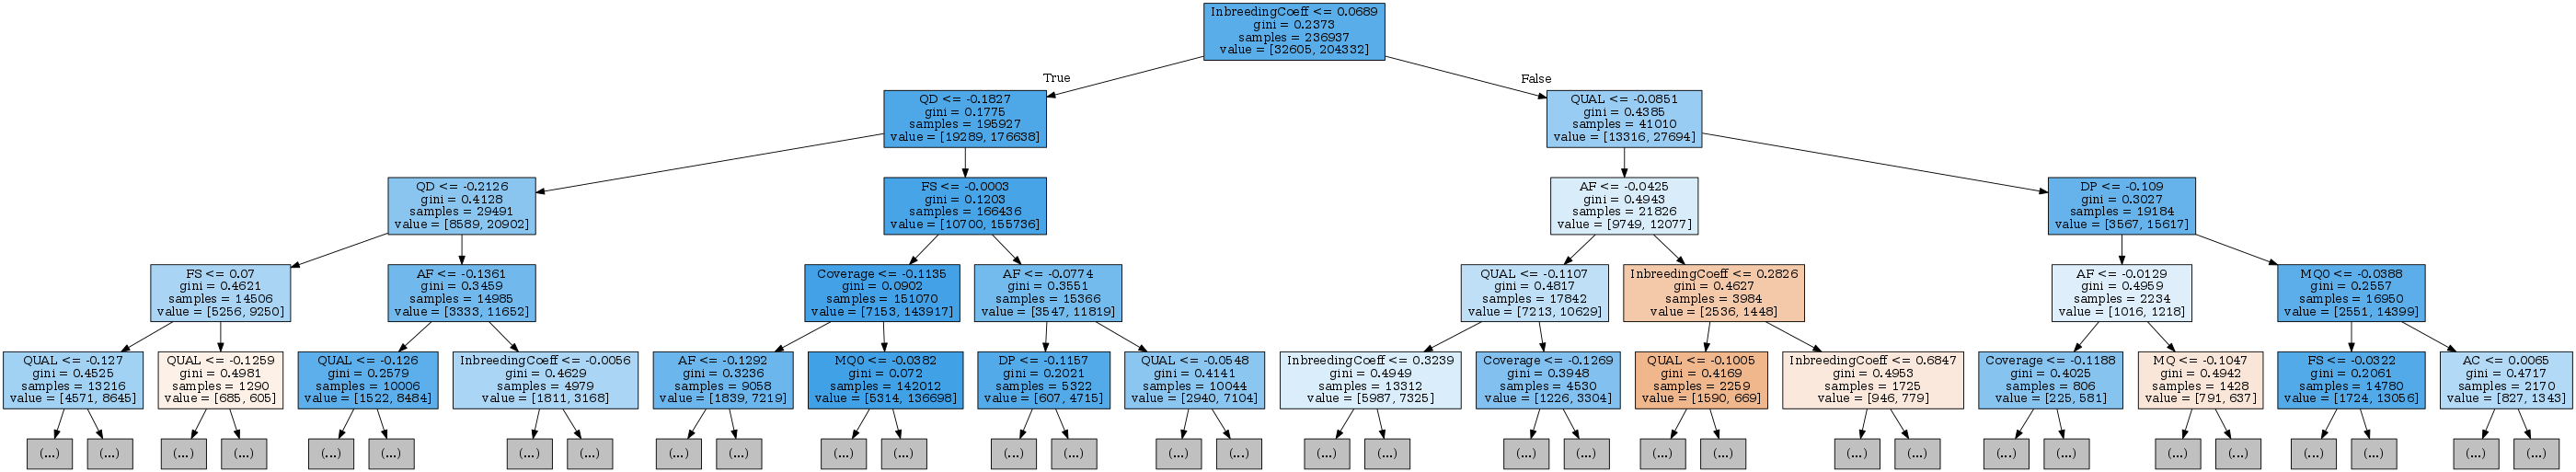

In [39]:
my_tree, img = get_tree(train_pre, annotations)
img

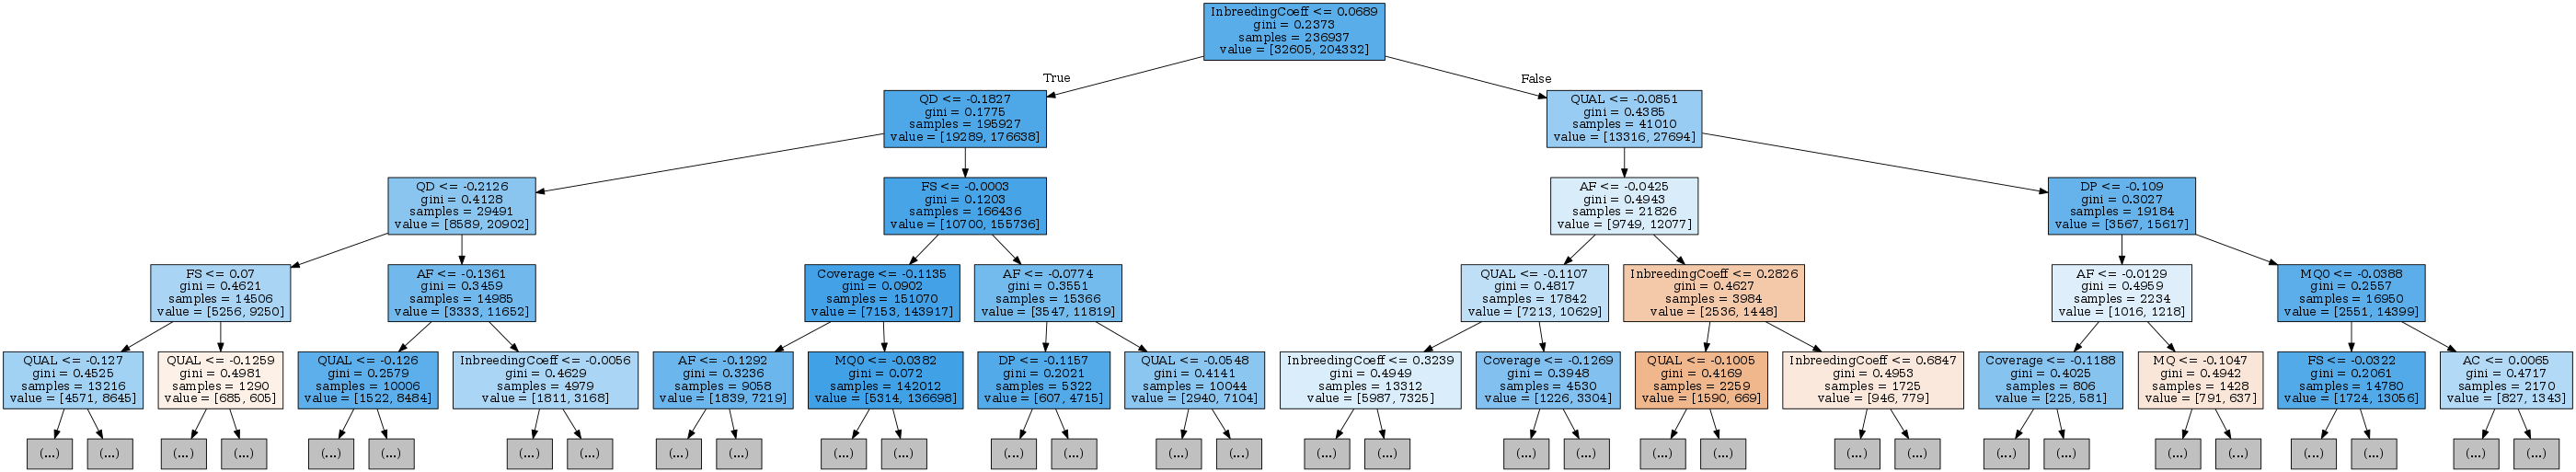

In [40]:
my_tree_no, img = get_tree(train_no_norm, annotations)
img

## Random forest

In [41]:
forest_clf = RandomForestClassifier()
my_forest = forest_clf.fit(train_pre[annotations], train_pre['OK'])

In [42]:
for feat, imp in zip(annotations, my_forest.feature_importances_):
    print(feat, imp)

AC 0.0640212336336
AF 0.0666942356404
AN 0.0589646888976
Coverage 0.0662535133326
DP 0.0863751744283
HRun 0.0284606748258
HaplotypeScore 0.0535248676055
InbreedingCoeff 0.0980679529601
MLEAC 0.060582677976
MQ 0.0571499937446
MQ0 0.0359055503403
QD 0.0948435414682
QUAL 0.0988197243121
POS 0.0554101863732
FS 0.0749259844616


## PCA

In [43]:
ssize = 1000
#train_ok = train_pre[train_pre['OK'] == 1].sample(ssize)
#train_err = train_pre[train_pre['OK'] == 0].sample(ssize)
train_ok = train_no_norm[train_no_norm['OK'] == 1].sample(ssize)
train_err = train_no_norm[train_no_norm['OK'] == 0].sample(ssize)
both_train = pd.concat([train_ok, train_err])
both_pca = PCA(n_components=4)
both_pca.fit(both_train[annotations])
both_trans = both_pca.transform(both_train[annotations])
both_trans = pd.DataFrame(both_trans, columns=['pc1', 'pc2', 'pc3', 'pc4'], index=both_train.index)
both_trans = pd.concat([both_train, pd.DataFrame(both_trans)], axis=1)
both_trans.shape

(2000, 20)

In [44]:
def plot_pca(trans, annotations, c1, c2):
    #print(trans['OK'])
    fig, axs = plt.subplots(5, 4, squeeze=False, sharex=True, sharey=True, figsize=(18, 18))
    axs[0, 0].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 0].set_title('PCA: Basic')
    
    trans_ok = trans[trans['OK'] == 1]
    axs[0, 1].scatter(trans_ok[c1].as_matrix(), trans_ok[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 1].set_title('OK')

    trans_err = trans[trans['OK'] == 0]
    axs[0, 2].scatter(trans_err[c1].as_matrix(), trans_err[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 2].set_title('Error')
    
    row = 0
    col = 3

    for annotation in annotations:
        axs[row, col].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(),
                              edgecolors='face', c=trans[annotation].as_matrix())
        axs[row, col].set_title(annotation)
        if col == 3:
            row += 1
            col = 0
        else:
            col += 1
    return fig

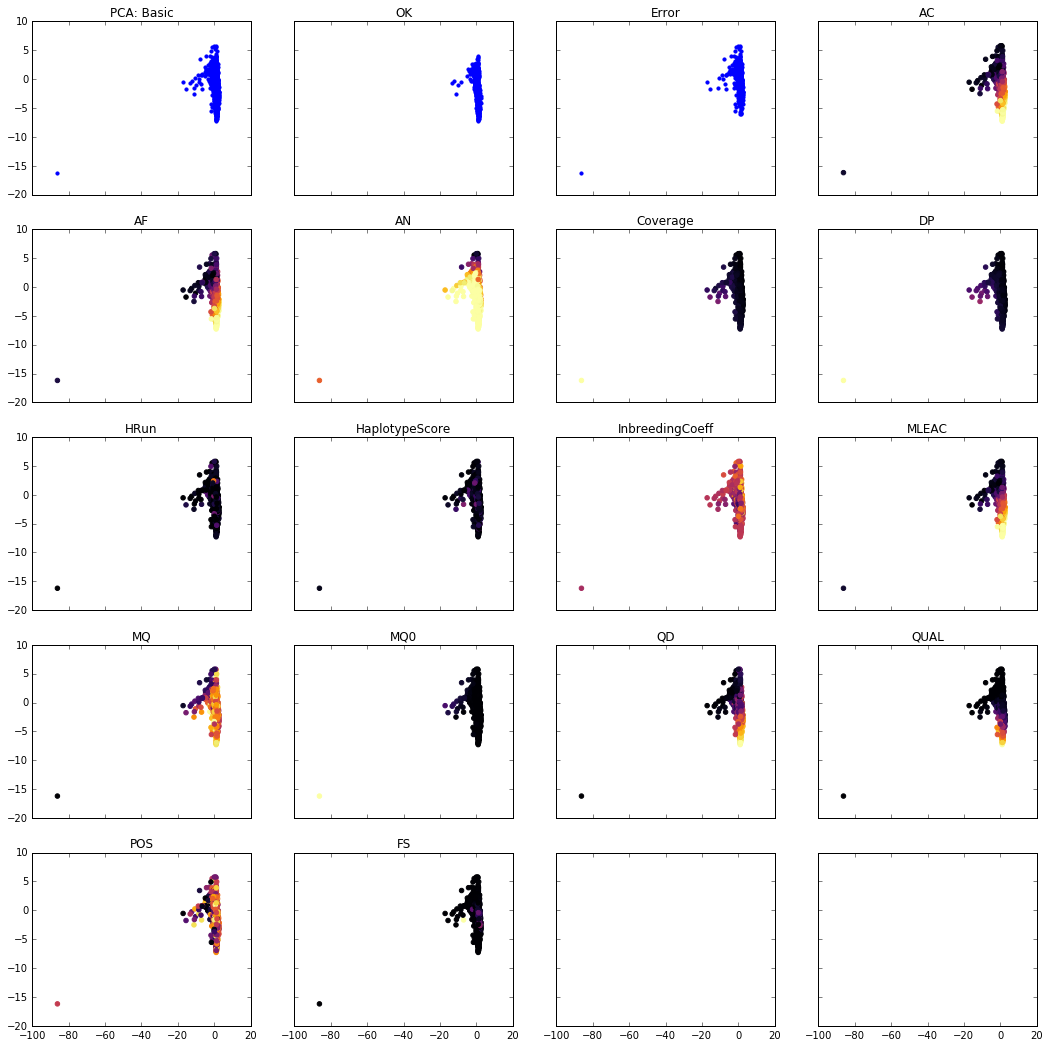

In [45]:
plt.rcParams['image.cmap'] = 'inferno'
plot_pca(both_trans, annotations, 'pc1', 'pc2')
pass

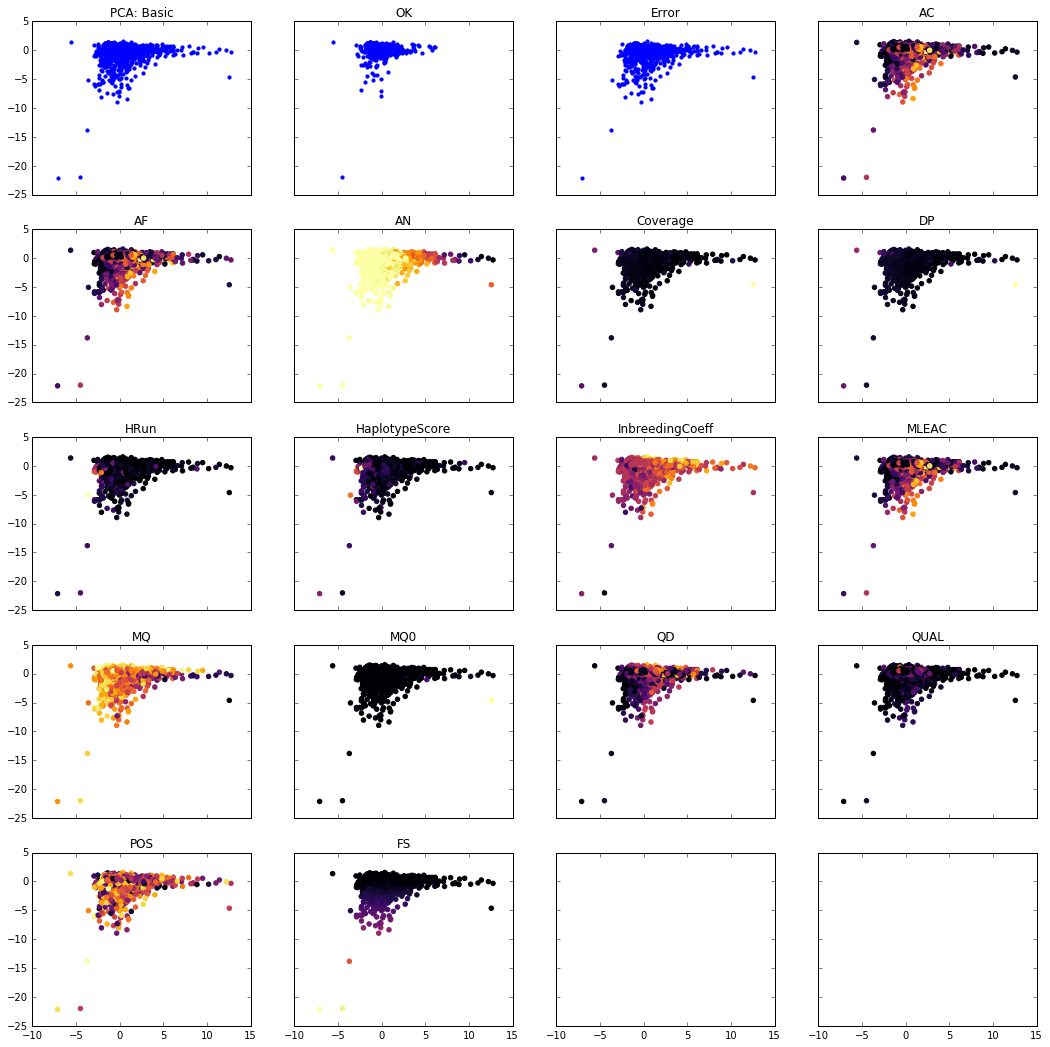

In [46]:
plot_pca(both_trans, annotations, 'pc3', 'pc4')
pass

## Covariance

In [47]:
train_pre[annotations].cov()

,AC,AF,AN,Coverage,DP,HRun,HaplotypeScore,InbreedingCoeff,MLEAC,MQ,MQ0,QD,QUAL,POS,FS
AC,1.000004,0.995305,0.589496,0.508193,0.536685,0.297273,0.373328,-0.300001,0.998676,0.572060,0.308488,0.825986,0.801062,-0.550335,0.305522
AF,0.995305,1.000004,0.595068,0.510147,0.531708,0.308379,0.373477,-0.287254,0.992832,0.578674,0.312577,0.824039,0.785610,-0.550354,0.303087
AN,0.589496,0.595068,1.000004,0.825092,0.865196,0.540204,0.541874,-0.334604,0.566476,0.948005,0.540166,0.612122,0.333767,-0.647767,0.268654
Coverage,0.508193,0.510147,0.825092,1.000004,0.929296,0.426696,0.543306,-0.379520,0.492526,0.742050,0.623980,0.488930,0.318980,-0.775964,0.242108
DP,0.536685,0.531708,0.865196,0.929296,1.000004,0.419984,0.548357,-0.405240,0.522157,0.801594,0.613885,0.521710,0.372373,-0.742142,0.254182
HRun,0.297273,0.308379,0.540204,0.426696,0.419984,1.000004,0.336987,-0.237324,0.287145,0.547063,0.201734,0.305330,0.152348,-0.284230,0.167089
HaplotypeScore,0.373328,0.373477,0.541874,0.543306,0.548357,0.336987,1.000004,-0.353929,0.363735,0.518448,0.241935,0.353919,0.240363,-0.390434,0.242728
InbreedingCoeff,-0.300001,-0.287254,-0.334604,-0.379520,-0.405240,-0.237324,-0.353929,1.000004,-0.304708,-0.340458,-0.149855,-0.202374,-0.353544,0.401697,-0.265010
MLEAC,0.998676,0.992832,0.566476,0.492526,0.522157,0.287145,0.363735,-0.304708,1.000004,0.551068,0.294609,0.828806,0.808214,-0.542098,0.300467
MQ,0.572060,0.578674,0.948005,0.742050,0.801594,0.547063,0.518448,-0.340458,0.551068,1.000004,0.322181,0.660369,0.377708,-0.555567,0.240380


## Re-analyze

In [48]:
reduced_annotations = ['DP', 'HRun', 'MQ', 'QD', 'QUAL', 'FS']

In [49]:
train_reduced = get_train(reduced_annotations)

In [50]:
train_reduced_no_norm = get_train(reduced_annotations, normalize=False)

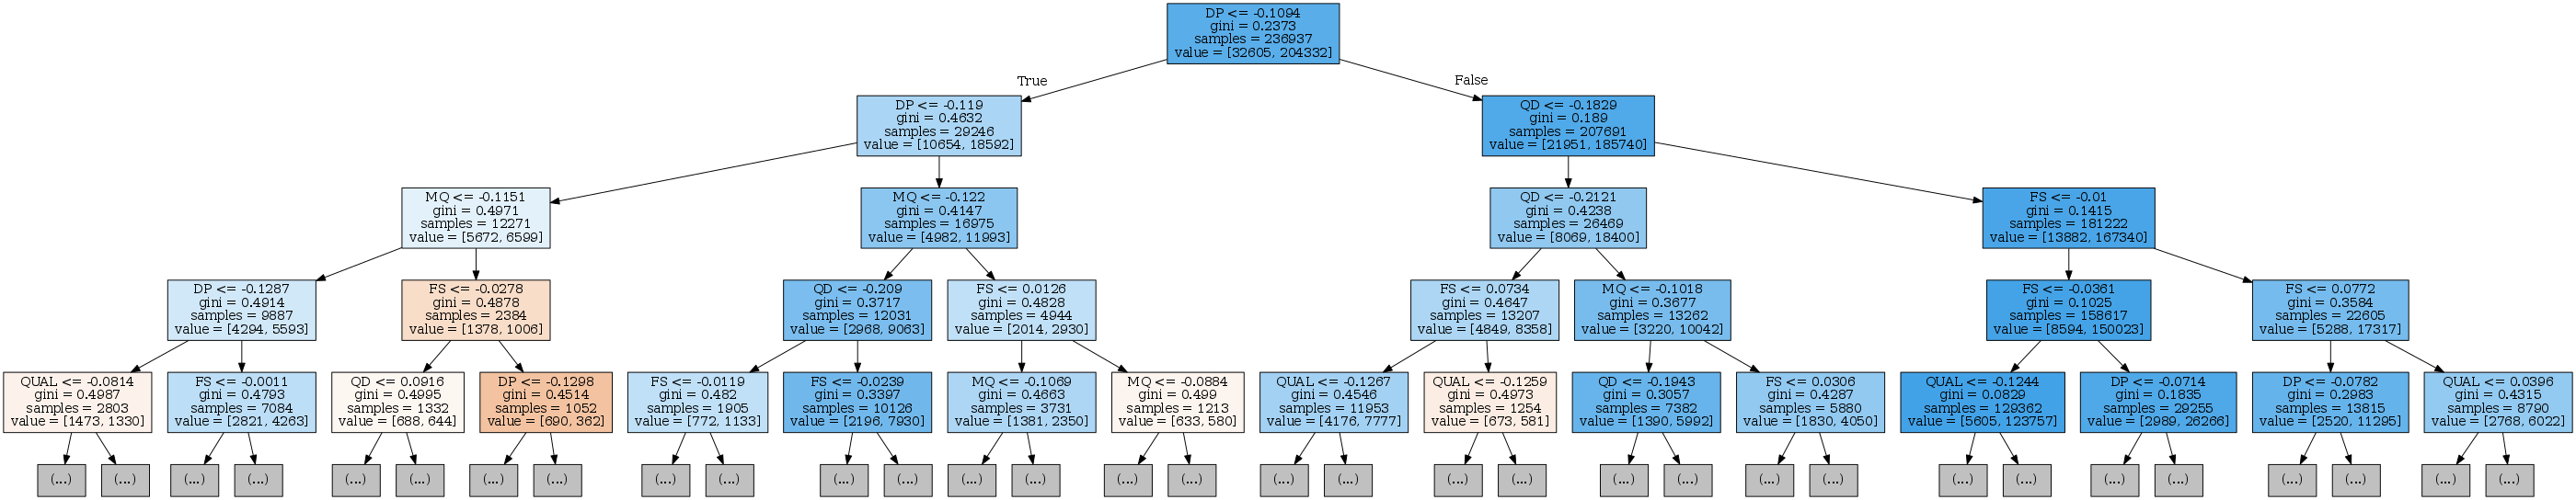

In [51]:
tree_reduced, img_reduced = get_tree(train_reduced, reduced_annotations)
img_reduced

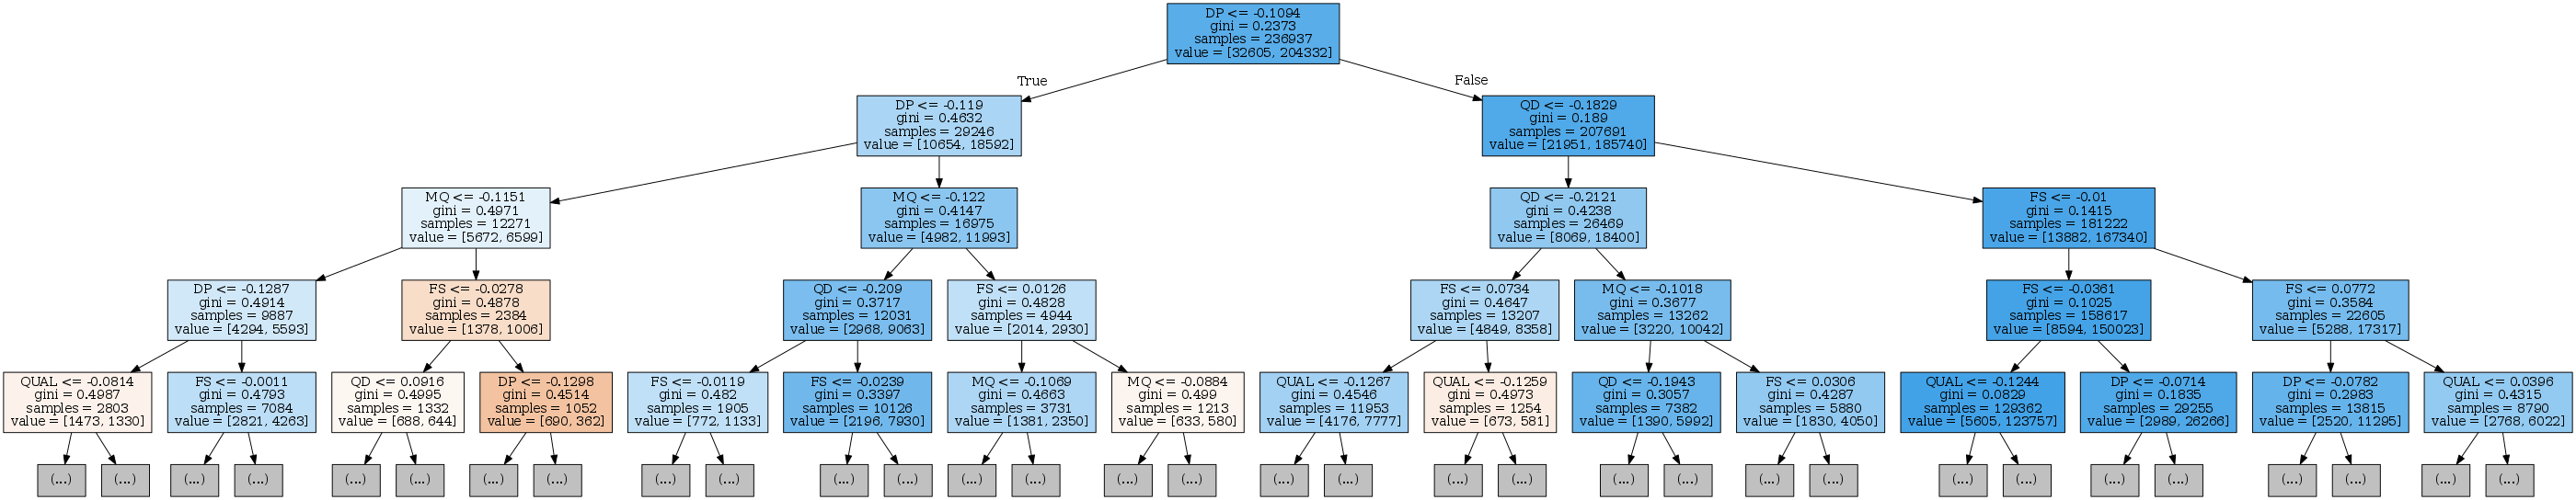

In [52]:
tree_reduced_no, img_reduced = get_tree(train_reduced_no_norm, reduced_annotations)
img_reduced

In [53]:
forest_reduced_clf = RandomForestClassifier()
forest_reduced = forest_clf.fit(train_reduced[reduced_annotations], train_reduced['OK'])

In [54]:
for feat, imp in zip(reduced_annotations, forest_reduced.feature_importances_):
    print(feat, imp)

DP 0.172667248408
HRun 0.0773427128548
MQ 0.208177173436
QD 0.1781445968
QUAL 0.17087457544
FS 0.19279369306


In [55]:
train_reduced[reduced_annotations].cov()

,DP,HRun,MQ,QD,QUAL,FS
DP,1.000004,0.321190,0.744917,0.278582,-0.909569,0.296643
HRun,0.321190,1.000004,0.397528,0.208873,-0.327545,0.227695
MQ,0.744917,0.397528,1.000004,0.611801,-0.678871,0.327387
QD,0.278582,0.208873,0.611801,1.000004,-0.102217,0.082132
QUAL,-0.909569,-0.327545,-0.678871,-0.102217,1.000004,-0.290011
FS,0.296643,0.227695,0.327387,0.082132,-0.290011,1.000004


In [56]:
ssize = 1000
train_reduced_ok = train_reduced[train_reduced['OK'] == 1].sample(ssize)
train_reduced_err = train_reduced[train_reduced['OK'] == 0].sample(ssize)
both_train_reduced = pd.concat([train_reduced_ok, train_reduced_err])
both_pca_reduced = PCA(n_components=4)
both_pca_reduced.fit(both_train_reduced[reduced_annotations])
both_trans_reduced = both_pca_reduced.transform(both_train_reduced[reduced_annotations])
both_trans_reduced = pd.DataFrame(both_trans_reduced, columns=['pc1', 'pc2', 'pc3', 'pc4'], index=both_train_reduced.index)
both_trans_reduced = pd.concat([both_train_reduced, pd.DataFrame(both_trans_reduced)], axis=1)
both_trans_reduced.shape

(2000, 11)

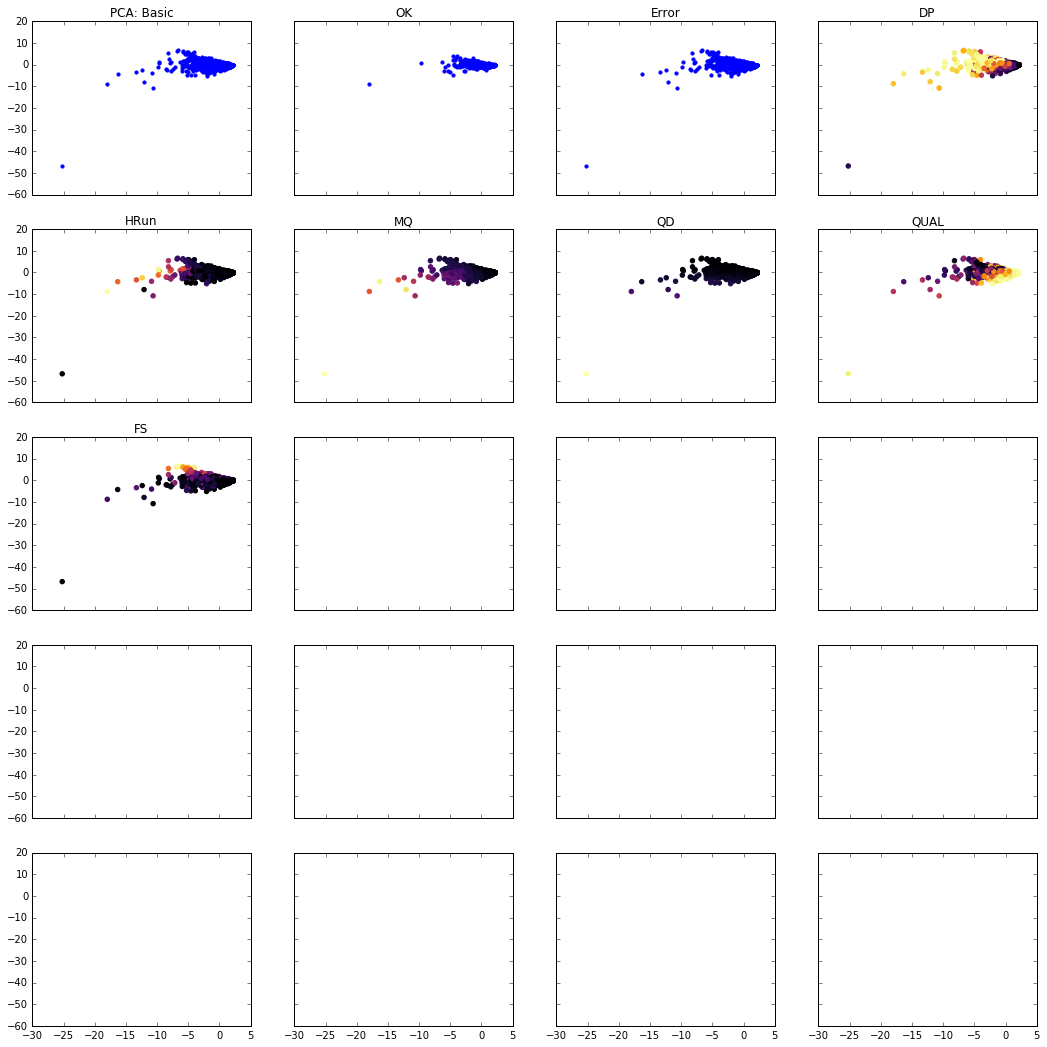

In [57]:
plot_pca(both_trans_reduced, reduced_annotations, 'pc1', 'pc2')
pass

## Regressor

In [58]:
both_train_reduced_again = pd.concat([train_reduced_ok, train_reduced_err])
train_reduced_with_scale, scaler = get_train(reduced_annotations, True)

In [59]:
ssize = 1000

train_reduced_ok_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 1].sample(ssize)
train_reduced_err_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 0].sample(ssize)

both_train_reduced_sc = pd.concat([train_reduced_ok_sc, train_reduced_err_sc])

In [60]:
clf = linear_model.LogisticRegression()
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
#clf = linear_model.SGDClassifier()
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)
clf.fit(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
clf.score(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))


0.88600000000000001

In [62]:
#both_train_reduced_sc[reduced_annotations].columns, np.transpose(clf.coef_)

In [63]:
my_parents = parents[0]
ofs_mo = samples.index(my_parents[0])
ofs_fa = samples.index(my_parents[1])
ofs_start, ofs_end = get_offspring_range(my_parents, parents, samples)

annot_dict = {}
for annotation in reduced_annotations:
    annot_dict[annotation] = store_3L.get_node('/3L/variants/%s' % annotation).read()


i = 0
test_results = collections.OrderedDict()
all_entries = []
all_Y = []
for i, pos in enumerate(poses):
    genotype = genotypes[i]
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    my_entry = []
    for annotation in reduced_annotations:
        my_entry.append(annot_dict[annotation][i])
    errors = compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    if errors is None:
        cnt = None
    else:
        total, cnt, cnt_mo, cnt_fa = errors
        all_Y.append(0 if cnt > 0 else 1)
        all_entries.append(my_entry)
    i += 1
    if i == 1000:
        break

ready_data = scaler.transform(preprocessing.normalize(all_entries))
prediction = clf.predict(ready_data)
test_results[pos] = cnt, prediction[0]
del annot_dict

In [64]:
clf.score(ready_data, all_Y)

0.63451086956521741

In [65]:
num_errors = 0
for cnt, prediction in zip(all_Y, all_entries):
    print(cnt, prediction)
    if cnt > 0 and prediction[0] == 0:
        num_errors += 1 

0 [2556, 0, 11.398, 2.3301, 2796.01, 0.0]
0 [3331, 0, 11.852, 2.3398, 4751.7002, 1.1309]
0 [3291, 0, 11.906, 2.2598, 3833.72, 66.812]
0 [3109, 1, 12.609, 2.5898, 4202.7998, 72.688]
0 [3105, 0, 12.992, 0.22998, 89.580002, 183.88]
1 [3105, 3, 12.109, 0.10999, 51.18, 161.0]
1 [3189, 1, 11.492, 1.4102, 784.38, 5.7969]
0 [1302, 1, 11.68, 0.75977, 37.0, 16.359]
0 [1337, 0, 10.0, 1.29, 68.25, 23.875]
0 [1370, 0, 9.7422, 1.3096, 69.489998, 24.594]
0 [1422, 1, 8.6094, 1.2998, 73.980003, 26.516]
0 [1438, 0, 8.1172, 2.8691, 392.95001, 35.656]
0 [1497, 2, 7.4297, 1.2998, 75.650002, 33.625]
0 [378, 2, 30.0, 2.4805, 91.779999, 2.9668]
0 [363, 1, 30.938, 1.0098, 30.43, 1.6006]
0 [387, 1, 29.344, 2.2793, 70.720001, 16.594]
0 [345, 1, 32.031, 4.3906, 706.20001, 3.6914]
0 [352, 1, 31.234, 4.2812, 171.33, 0.0]
0 [347, 1, 31.203, 2.3809, 35.77, 0.0]
1 [367, 2, 32.656, 0.7998, 37.369999, 3.2734]
0 [765, 0, 22.203, 0.6001, 45.009998, 19.516]
1 [659, 0, 20.844, 0.6499, 51.27, 19.484]
0 [345, 1, 29.234, 7.058

In [66]:
store_3L

File(filename=../raw/crosses-3L.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/3L (Group) ''
/3L/samples (Array(80,)) ''
  atom := StringAtom(itemsize=8, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/3L/calldata (Group) ''
/3L/calldata/AD (EArray(2501730, 80, 2), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (3276, 10, 2)
/3L/calldata/DP (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (6553, 10)
/3L/calldata/GQ (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (13107, 10)
/3L/calldata/GT (EArray(2501730, 80), shuffle, zlib(1)